
# LangGraph Reflection 机制开发指南

本指南详细介绍了如何在 **LangGraph** 中构建基于大语言模型（LLM）的 **Reflection（反思）** 机制。

Reflection 是一种重要的模型能力，通过让模型观察其过去的步骤和外部环境反馈，评估自身行为的质量，并不断改进输出。在生成与反思的循环中，模型可以逐步优化内容，从而提升生成质量和用户满意度。

Reflection 机制被广泛应用于生成任务中，例如文章写作、内容修改与反馈、以及智能助理等场景。通过引导 LLM 进行自我反思和用户反馈处理，开发者可以让模型在多轮交互中自动调整其生成的内容，达到高效、精准、结构完善的输出。



在本指南中，我们会逐步演示如何搭建这一机制，包括从基础的环境配置到生成器和反思器的构建，再到如何使用 LangGraph 状态图实现生成-反思循环的完整流程。无论您是为文章生成、内容评估，还是其他复杂任务设计 LLM 代理，本指南都将为您提供详细的开发思路和实用的代码示例。

![reflection](./images/reflection.png)

通过本指南，您将学习如何：
1. 设置开发环境并安装所需包；
2. 定义和生成灵活结构的文章，不局限于传统的五段式；
3. 通过反思机制批改生成内容，并提供详细反馈；
4. 构建反思与生成的状态循环，使模型持续改进生成内容。

本开发指南适合任何希望构建复杂 LLM 任务的开发者，特别是需要实现生成-反思流程、文章批改反馈、或其他高级交互任务的场景。


## 1. 环境设置
首先，安装所需的包并设置API密钥：

In [1]:
%%capture --no-stderr
%pip install langchain langgraph langchain-ollama tavily-python

In [21]:
import os
tavily_api_key = os.getenv('TAVILY_API_KEY')
langsmith_api_key = os.getenv('LANGSMITH_API_KEY')
openai_api_key = os.getenv("OPENAI_API_KEY")
base_url="https://api.javis3000.com/v1"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
LANGCHAIN_PROJECT="反思智能体homework"  #建立langsmith上的项目
os.environ["LANGCHAIN_PROJECT"] = "反思智能体homework"#读入环境变量


In [4]:
#运行一次有数据上传了项目就自动在langsmith中建立了
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini",base_url=base_url)
llm.invoke("Hello, world!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 11, 'total_tokens': 20}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_80a1bad4c7', 'finish_reason': 'stop', 'logprobs': None}, id='run-0631a073-2d44-49c2-82f3-3c65d2b7763d-0', usage_metadata={'input_tokens': 11, 'output_tokens': 9, 'total_tokens': 20})

## 2. LangSmith开发配置
LangSmith能够帮助您快速发现问题并提高LangGraph项目的性能。通过LangSmith，您可以使用跟踪数据来调试、测试和监控基于LangGraph构建的LLM应用程序。

## 3. 定义写作助手智能体

我们定义的这个助手是一个写作助手，旨在为用户生成高质量、结构清晰且引人入胜的文章。它的任务是根据用户的请求撰写内容，无论是短文、长篇、议论文还是其他类型的文章，都能够灵活应对。助手会专注于文章的清晰度、结构和质量，确保输出的内容是精心打磨过的。如果用户对生成的内容有反馈或建议，助手还能够根据这些反馈改进和优化文章，使其更符合用户的期望。这种互动机制保证了写作过程的灵活性和个性化，从而让用户获得更符合需求的成品。


### System Prompt 详细解释：
1. **"You are a writing assistant"**：写作助手的角色设定，让模型明确其任务是帮助用户进行写作。
   
2. **"well-crafted, coherent, and engaging articles"**：描述了文章应该具备的特性，包括“精心撰写的、连贯的和吸引人的”，但没有限制文章的具体结构，可以是不同类型的文章（如叙述文、议论文等）。

3. **"Focus on clarity, structure, and quality"**：明确了撰写时需要关注的核心要素：清晰度、结构性和质量，确保输出内容优秀。

4. **"revise and improve the writing"**：模型可以根据用户的反馈进行修改和优化，保持互动的灵活性。


In [22]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_ollama.chat_models import ChatOllama

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a writing assistant tasked with creating well-crafted, coherent, and engaging articles based on the user's request."
            " Focus on clarity, structure, and quality to produce the best possible piece of writing."
            " If the user provides feedback or suggestions, revise and improve the writing to better align with their expectations.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

llm = ChatOpenAI( base_url=base_url,model="gpt-4o")

In [23]:
writer = writer_prompt | llm

In [24]:
article = ""

topic = HumanMessage(
    content="参考水浒传的风格，改写吴承恩的西游记中任意篇章"
)

for chunk in writer.stream({"messages": [topic]}):
    print(chunk.content, end="")
    article += chunk.content

好的，我会选择《西游记》中的一个经典片段，借鉴《水浒传》的风格进行改写。为了保持故事的连贯性，我将选择“孙悟空大闹天宫”这一章进行改写：

---

话说那花果山水帘洞，乃是天造地设的一处宝地。山中有一石猴，自小聪慧异常，拜师学艺，得了一身神通。此猴不甘寂寞，遂自称齐天大圣，率领群猴称王称霸，闹得四方不宁。

一日，这石猴大圣对群猴道：“兄弟们，天庭那帮神仙自恃高高在上，岂知咱们山中也是一方豪杰！今日我便上天去讨个说法，看他们如何回应！”群猴闻言，齐声喝彩，纷纷赞颂大圣英勇无敌。

孙悟空腾云驾雾，直奔南天门。守门的天将见他来势汹汹，急忙报与玉帝。玉帝闻讯，大怒道：“这泼猴好生无礼，竟敢擅闯天门！传旨，叫托塔李天王带兵去降他！”

李天王领命，带领天兵天将杀向花果山。却不料孙悟空早有准备，他率领群猴与天兵激战，一时之间杀得天昏地暗，日月无光。那李天王见势不妙，急令哪吒三太子上前助战。

哪吒变作三头六臂，舞动火尖枪，直取孙悟空。二人战得天崩地裂，难解难分。孙悟空见哪吒勇猛，心中暗赞：“这小子倒是有两下子，不过今日我定要叫你知我厉害！”

说罢，孙悟空使出七十二变，化作一只苍鹰，直扑哪吒面门。哪吒挥舞火尖枪迎敌，二人又斗了三百回合。最后，孙悟空使出如意金箍棒，棒若山岳，力如雷霆，一棒打得哪吒退避三舍。

天庭众仙见状，纷纷求玉帝赦免。玉帝无奈，只得传旨封孙悟空为“弼马温”，意在安抚。孙悟空不知这是个小小的官职，还以为得了荣宠，遂欢天喜地，回到花果山。

岂料，待他知道真相后，怒不可遏，重返天庭，大闹蟠桃会，偷吃仙丹，闹得天庭上下鸡犬不宁。玉帝无奈，只得请来如来佛祖。佛祖以五指山镇压孙悟空，终将其困住。

---

这样改写的版本借鉴了《水浒传》的叙事风格，注重描写人物的豪爽和战斗的激烈，希望符合您的要求。如果有任何修改意见，请随时告诉我！

In [25]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(article))

好的，我会选择《西游记》中的一个经典片段，借鉴《水浒传》的风格进行改写。为了保持故事的连贯性，我将选择“孙悟空大闹天宫”这一章进行改写：

---

话说那花果山水帘洞，乃是天造地设的一处宝地。山中有一石猴，自小聪慧异常，拜师学艺，得了一身神通。此猴不甘寂寞，遂自称齐天大圣，率领群猴称王称霸，闹得四方不宁。

一日，这石猴大圣对群猴道：“兄弟们，天庭那帮神仙自恃高高在上，岂知咱们山中也是一方豪杰！今日我便上天去讨个说法，看他们如何回应！”群猴闻言，齐声喝彩，纷纷赞颂大圣英勇无敌。

孙悟空腾云驾雾，直奔南天门。守门的天将见他来势汹汹，急忙报与玉帝。玉帝闻讯，大怒道：“这泼猴好生无礼，竟敢擅闯天门！传旨，叫托塔李天王带兵去降他！”

李天王领命，带领天兵天将杀向花果山。却不料孙悟空早有准备，他率领群猴与天兵激战，一时之间杀得天昏地暗，日月无光。那李天王见势不妙，急令哪吒三太子上前助战。

哪吒变作三头六臂，舞动火尖枪，直取孙悟空。二人战得天崩地裂，难解难分。孙悟空见哪吒勇猛，心中暗赞：“这小子倒是有两下子，不过今日我定要叫你知我厉害！”

说罢，孙悟空使出七十二变，化作一只苍鹰，直扑哪吒面门。哪吒挥舞火尖枪迎敌，二人又斗了三百回合。最后，孙悟空使出如意金箍棒，棒若山岳，力如雷霆，一棒打得哪吒退避三舍。

天庭众仙见状，纷纷求玉帝赦免。玉帝无奈，只得传旨封孙悟空为“弼马温”，意在安抚。孙悟空不知这是个小小的官职，还以为得了荣宠，遂欢天喜地，回到花果山。

岂料，待他知道真相后，怒不可遏，重返天庭，大闹蟠桃会，偷吃仙丹，闹得天庭上下鸡犬不宁。玉帝无奈，只得请来如来佛祖。佛祖以五指山镇压孙悟空，终将其困住。

---

这样改写的版本借鉴了《水浒传》的叙事风格，注重描写人物的豪爽和战斗的激烈，希望符合您的要求。如果有任何修改意见，请随时告诉我！

----------
## 4. 定义审阅老师智能体

下面我们使用反思机制批改生成的作文，生成一篇作文的反馈和建议。

模型扮演“老师”角色，针对用户提交的作文进行打分、批改和提供改进建议。

### System Prompt 详细解释：

- **"You are a teacher grading an essay submission."**
  - 模型被设定为一个老师角色，专门负责为用户提交的作文进行批改。这一角色定位帮助模型理解其任务是提供具有建设性的反馈和评价。
  
- **"Generate critique and recommendations for the user's submission."**
  - 模型需要生成作文的批评与建议。它不只是评估作文的好坏，还需要指出需要改进的地方，并提出具体的建议。

- **"Provide detailed recommendations, including requests for length, depth, style, etc."**
  - 这一部分进一步明确了反馈的细节，要求模型给出细致的建议。这包括：
    - **Length（长度）**：文章的字数是否合适，是否需要扩展或删减。
    - **Depth（深度）**：是否需要更深入的分析或讨论。
    - **Style（风格）**：文章的写作风格是否合适，是否符合目标读者或主题的需求。
  
这一设定确保了模型不仅给出基本反馈，还可以根据文章的具体问题提出具体的改进意见，帮助用户更好地提升其写作。

In [26]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an article submission. writer critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",

        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflect = reflection_prompt | llm

In [27]:
reflection = ""

# 将主题（topic）和生成的文章（article）作为输入发送给反思智能体
for chunk in reflect.stream({"messages": [topic, HumanMessage(content=article)]}):
    print(chunk.content, end="")
    reflection += chunk.content

### 评语与建议

感谢你提交的改写版本，将《西游记》的“孙悟空大闹天宫”这一章用《水浒传》的风格进行了重新演绎。整体上，你成功地捕捉到了《水浒传》的某些叙事特点，如豪爽的语气和战斗场面的描写。以下是详细的评语和建议：

#### 优点：
1. **叙事风格**：你在叙述中使用了较为直白和豪迈的语言风格，这与《水浒传》中的风格较为接近。
2. **人物刻画**：孙悟空的骄傲与勇猛，以及战斗场面的激烈，都得到了很好的展现。
3. **情节紧凑**：故事情节紧凑，战斗描写较为生动，符合《水浒传》中战斗描写的特点。

#### 建议：
1. **细节描写**：可以增加更多的细节描写，特别是环境和人物的心理活动。这有助于丰富故事的层次感。例如，在战斗场面中，可以更详细地描写双方的武器碰撞、动作细节以及周围环境的变化。
   
2. **对话描写**：增加更多的对话描写，尤其是孙悟空与其他人物之间的对话。《水浒传》中的对话常常生动且富有地方色彩，可以借鉴这一点来增加人物的立体感。

3. **语言风格**：虽然整体语言风格较为豪爽，但有些地方还可以更加贴近《水浒传》的口语化风格。例如，使用更多的俚语或地方方言，以及更加粗犷的语气。

4. **情感渲染**：可以加强对人物情感的渲染，特别是在关键情节中。例如，孙悟空被封为弼马温后的失望和愤怒，可以通过更多的内心独白和情感爆发来表现。

5. **篇幅扩展**：可以适当扩展篇幅，增加更多的情节细节和人物互动，使故事更加丰满和具有吸引力。

#### 示例改写建议：
```markdown
话说那花果山水帘洞，乃是天造地设的一处宝地。山中有一石猴，自小聪慧异常，拜师学艺，得了一身神通。此猴不甘寂寞，遂自称齐天大圣，率领群猴称王称霸，闹得四方不宁。

一日，这石猴大圣对群猴道：“兄弟们，天庭那帮神仙自恃高高在上，岂知咱们山中也是一方豪杰！今日我便上天去讨个说法，看他们如何回应！”群猴闻言，齐声喝彩，纷纷赞颂大圣英勇无敌。

孙悟空腾云驾雾，直奔南天门。守门的天将见他来势汹汹，急忙报与玉帝。玉帝闻讯，大怒道：“这泼猴好生无礼，竟敢擅闯天门！传旨，叫托塔李天王带兵去降他！”

李天王领命，带领天兵天将杀向花果山。却不料孙悟空早有准备，他率领群猴与天兵激战，一时之间杀得天昏地暗，日月无光。那李天王见势不妙，急令哪吒三太子上前助战。

哪

In [10]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(reflection))

你的改写版本很好，但仍然需要一些调整来更好地体现水浒传的风格和特点。以下是我的建议：

**长度**: 水浒传的篇幅通常较长，平均每个故事大约有 10-15 个节。你的改写版本应该增加到至少 5-7 节，以便更好地展现宋江与白骨精之间的斗智和情感。

**人物性格**: 水浒传中的角色往往具有鲜明的个性和特点。你的改写版本中，宋江的智慧和幽默感很好，但白骨精的性格需要更多发展。她应该表现出更强烈的情绪波动和复杂的人物心理。

**情节**: 水浒传中的故事通常具有明显的起承转合结构。你的改写版本中，情节有些跳跃，不太清楚白骨精为什么会迷惑仙女，也没有很好地展现宋江与白骨精之间的斗智过程。

**语言风格**: 水浒传的语言风格通常较为生动、形象和俏皮。你的改写版本中，语言风格还需要进一步提高，以便更好地体现水浒传的特点。

具体来说，你可以尝试以下几点：

1. 增加情节的起承转合结构，使得故事更加流畅和逻辑。
2. 发展白骨精的性格，表现出她的复杂的人物心理和强烈的情绪波动。
3. 提高语言风格，使用更多的俚语、谚语和形象比喻，以便更好地体现水浒传的特点。
4. 增加对宋江与白骨精之间斗智过程的描述，使得故事更加生动和有趣。

总之，你的改写版本很好，但仍然需要进一步调整和完善，以便更好地体现水浒传的风格和特点。

In [28]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}


In [29]:
MAX_ROUND = 6

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
def should_continue(state: State):
    if len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

In [31]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")


# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

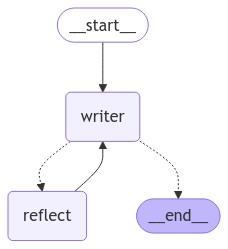

In [32]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [33]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 写作生成:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [34]:
inputs = {
    "messages": [
        HumanMessage(content="中年老爷们最可悲的事情，是做了很多事情，最终只是感动了自己，以此为主题写一篇激荡情绪的文章")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 1

#### 写作生成:
- 诸位青年才俊：

贫僧今日有幸与诸位共聚一堂，心中甚是欢喜。然则，贫僧心中亦有几句肺腑之言，欲与诸位共勉，望诸位不吝赐教。

人生如长河，岁月如梭，光阴似箭，弹指一挥间。年轻之时，正是奋斗拼搏的好时光，若不趁此时奋发图强，将来恐悔之晚矣。古人云：“少壮不努力，老大徒伤悲。”此言诚不我欺也。

贫僧虽生性愚钝，然亦知天道酬勤之理。尔等正值青春年华，当秉持一颗赤子之心，勤勉努力，不畏艰难。纵观古今中外，凡有成就之人，无不经历千辛万苦，方得功成名就。譬如我佛如来，亦须经历九九八十一难，方得正果。若无此等毅力与恒心，何来今日之光辉？

贫僧东渡大唐，历经千山万水，求取真经，亦是步步艰辛。然每逢困顿之时，常以心中大愿为念，方能不惧险阻，勇往直前。尔等当以此为鉴，莫为一时之困扰而退缩，莫为一时之安逸而放弃。须知，成功之路，虽布满荆棘，然其尽头必有光明。

贫僧常以为，世间之事，唯有持之以恒，方能有所成就。譬如农夫耕田，春种秋收，需日复一日耕作，方能得稻谷满仓。若今日懈怠，明日怠慢，终将一事无成。尔等亦当如此，工作之时，须专心致志，勤勤恳恳，不可三心二意，敷衍塞责。

再者，贫僧以为，凡事需有大志，方能成大业。人之所以为人，贵在有志。若无远大之志，何以成就一番事业？尔等当立志高远，以天下为己任，方能不负此生，不负父母师长之期望。

贫僧言尽于此，望诸位青年才俊，能以此为鉴，奋发图强，努力工作，方能在人生之路上，步步高升，终有所成。愿诸位前程似锦，大业有成。

阿弥陀佛。

此致，
唐三藏


## Round 2

#### 评论反思:
- 亲爱的作者，

感谢您提交的文章。在文章中，您成功地模仿了《西游记》中唐僧的说话风格，使用了古典的文言文体，传达了一些重要的价值观和人生哲理。以下是一些详细的反馈和建议，希望能帮助您进一步提升文章的质量。

### 优点
1. **文言文风格**：您很好地捕捉了唐僧的语言特点，使用了许多经典的文言文表达方式，如“贫僧”、“尔等”、“纵观古今中外”等，使得文章的风格与《西游记》中的唐僧形象相符。
2. **内容传达**：文章中传达了努力工作、持之以恒、立志高远等积极向上的价值观，这些内容对于年轻人来说非常重要。

### 需改进之处
1. **深度与细节**：
   - **实例引用**：虽然您提到了一些经典例子，如“我佛如来经历九九八十一难”，但这些例子可以进一步详细描述，以增强说服力。例如，可以简要叙述如来经历的某个具体困难和解决方法。
   - **具体建议**：除了宏观的劝勉，还可以加入一些具体的行动指导。例如，如何在日常生活中保持勤奋，如何设定并达成目标等。

2. **文章结构**：
   - **段落过渡**：段落之间的过渡可以更加平滑。例如，在讨论完勤奋之后，可以自然地引入立志的重要性，而不是突然转向。
   - **开头与结尾**：开头可以增加一些引人入胜的故事或问题，吸引读者的注意力。结尾部分虽然有总结，但可以更具激励性，呼应文章的开头。

3. **语言与风格**：
   - **简洁性**：文言文虽然有其独特的美感，但过于繁复的句式可能会让现代读者感到不适。可以适当简化一些复杂的句子，使其更易读。
   - **平衡古今**：虽然模仿唐僧的风格是一个亮点，但也要考虑现代读者的阅读习惯，可以适当加入一些通俗易懂的现代语言，增强文章的可读性。

### 具体修改建议
1. **增加具体例子**：例如，在提到“我佛如来，亦须经历九九八十一难”时，可以详细描述其中之一的具体情境和解决办法。
   
   **原文**：
   > 譬如我佛如来，亦须经历九九八十一难，方得正果。

   **修改建议**：
   > 譬如我佛如来，亦须经历九九八十一难，其中曾有一次面对火焰山，四周烈火熊熊，无处可逃。然如来心中大愿不灭，最终借助孙悟空之力，化险为夷，终得正果。

2. **添加具体的行动指导**：
   
   **原文**：
   > 尔等当以此为鉴，莫为一时之困扰而退缩，莫为一时之安逸而放弃。

   **修改建议**：
   > 尔等当以此为鉴，莫为一时之困扰而退缩，莫为一时之安逸而放弃。可以每日早起一小时，阅读经典，增强学识；亦可设定每周目标，逐步实现，累积成就。

3. **段落过渡更加平滑**：

   **原文**：
   > 贫僧言尽于此，望诸位青年才俊，能以此为鉴，奋发图强，努力工作，方能在人生之路上，步步高升，终有所成。

   **修改建议**：
   > 贫僧言尽于此，愿诸位青年才俊，能以此为鉴，奋发图强，努力工作。记住，成功之路虽布满荆棘，但持之以恒，终将步步高升，终有所成。

希望这些反馈和建议对您有所帮助。如果您有任何问题或需要进一步的指导，请随时联系我。

祝好，
[您的姓名]


## Round 3

#### 写作生成:
- 亲爱的青年才俊：

贫僧今日有幸与诸位共聚一堂，心中甚是欢喜。然则，贫僧心中亦有几句肺腑之言，欲与诸位共勉，望诸位不吝赐教。

人生如长河，岁月如梭，光阴似箭，弹指一挥间。年轻之时，正是奋斗拼搏的好时光，若不趁此时奋发图强，将来恐悔之晚矣。古人云：“少壮不努力，老大徒伤悲。”此言诚不我欺也。

贫僧虽生性愚钝，然亦知天道酬勤之理。尔等正值青春年华，当秉持一颗赤子之心，勤勉努力，不畏艰难。纵观古今中外，凡有成就之人，无不经历千辛万苦，方得功成名就。譬如我佛如来，亦须经历九九八十一难，其中曾有一次面对火焰山，四周烈火熊熊，无处可逃。然如来心中大愿不灭，最终借助孙悟空之力，化险为夷，终得正果。若无此等毅力与恒心，何来今日之光辉？

贫僧东渡大唐，历经千山万水，求取真经，亦是步步艰辛。然每逢困顿之时，常以心中大愿为念，方能不惧险阻，勇往直前。尔等当以此为鉴，莫为一时之困扰而退缩，莫为一时之安逸而放弃。须知，成功之路，虽布满荆棘，然其尽头必有光明。

贫僧常以为，世间之事，唯有持之以恒，方能有所成就。譬如农夫耕田，春种秋收，需日复一日耕作，方能得稻谷满仓。尔等亦当如此，工作之时，须专心致志，勤勤恳恳，不可三心二意，敷衍塞责。每日早起一小时，阅读经典，增强学识；亦可设定每周目标，逐步实现，累积成就。

再者，贫僧以为，凡事需有大志，方能成大业。人之所以为人，贵在有志。若无远大之志，何以成就一番事业？尔等当立志高远，以天下为己任，方能不负此生，不负父母师长之期望。

贫僧言尽于此，愿诸位青年才俊，能以此为鉴，奋发图强，努力工作。记住，成功之路虽布满荆棘，但持之以恒，终将步步高升，终有所成。愿诸位前程似锦，大业有成。

阿弥陀佛。

此致，
唐三藏


## Round 4

#### 评论反思:
- 亲爱的作者，

感谢您根据反馈所做的修改，文章显得更加丰富和具体。以下是进一步的反馈和建议，以帮助您进一步提升文章的质量。

### 优点
1. **细节补充**：您增加了具体的实例，如如来佛面对火焰山的描述，使文章内容更加生动和有说服力。
2. **实践建议**：加入了每日早起阅读和设定每周目标的具体建议，为读者提供了实际的行动指导。

### 进一步改进建议
1. **段落层次**：可以考虑将文章分为更清晰的几个部分，每部分有一个明确的主题。例如，第一部分强调勤奋的重要性，第二部分介绍如何克服困难，第三部分讨论持之以恒，第四部分讲述立志远大的重要性。
2. **语言平衡**：尽量在保持文言文风格的同时，使语言更为现代读者所接受。可以适当简化一些句子，或者插入一些现代汉语的解释。
3. **吸引开头**：开头可以更加吸引读者，比如通过一个简短的故事或问题引入主题。
4. **总结呼应**：结尾可以更加激励人心，并呼应开头提出的问题或故事。

### 具体修改建议
1. **段落层次**：

   **原文**：
   > 贫僧东渡大唐，历经千山万水，求取真经，亦是步步艰辛。然每逢困顿之时，常以心中大愿为念，方能不惧险阻，勇往直前。尔等当以此为鉴，莫为一时之困扰而退缩，莫为一时之安逸而放弃。须知，成功之路，虽布满荆棘，然其尽头必有光明。

   **修改建议**：
   > 贫僧东渡大唐，历经千山万水，求取真经，亦是步步艰辛。然每逢困顿之时，常以心中大愿为念，方能不惧险阻，勇往直前。尔等当以此为鉴，莫为一时之困扰而退缩，莫为一时之安逸而放弃。须知，成功之路，虽布满荆棘，然其尽头必有光明。

   > 贫僧常以为，世间之事，唯有持之以恒，方能有所成就。譬如农夫耕田，春种秋收，需日复一日耕作，方能得稻谷满仓。尔等亦当如此，工作之时，须专心致志，勤勤恳恳，不可三心二意，敷衍塞责。每日早起一小时，阅读经典，增强学识；亦可设定每周目标，逐步实现，累积成就。

2. **语言平衡**：

   **原文**：
   > 贫僧虽生性愚钝，然亦知天道酬勤之理。尔等正值青春年华，当秉持一颗赤子之心，勤勉努力，不畏艰难。

   **修改建议**：
   > 贫僧虽生性愚钝，然亦知天道酬勤之理。诸位正值青春年华，当秉持一颗赤子之心，勤勉努力，不畏艰难。

3. **吸引开头**：

   **原文**：
   > 贫僧今日有幸与诸位共聚一堂，心中甚是欢喜。然则，贫僧心中亦有几句肺腑之言，欲与诸位共勉，望诸位不吝赐教。

   **修改建议**：
   > 贫僧今日有幸与诸位共聚一堂，心中甚是欢喜。然则，贫僧心中亦有几句肺腑之言，欲与诸位共勉。人生如长河，岁月如梭，光阴似箭，弹指一挥间。年轻之时，正是奋斗拼搏的好时光，若不趁此时奋发图强，将来恐悔之晚矣。

### 示例修改后的文章
亲爱的青年才俊：

贫僧今日有幸与诸位共聚一堂，心中甚是欢喜。然则，贫僧心中亦有几句肺腑之言，欲与诸位共勉，望诸位不吝赐教。

人生如长河，岁月如梭，光阴似箭，弹指一挥间。年轻之时，正是奋斗拼搏的好时光，若不趁此时奋发图强，将来恐悔之晚矣。古人云：“少壮不努力，老大徒伤悲。”此言诚不我欺也。

贫僧虽生性愚钝，然亦知天道酬勤之理。诸位正值青春年华，当秉持一颗赤子之心，勤勉努力，不畏艰难。纵观古今中外，凡有成就之人，无不经历千辛万苦，方得功成名就。譬如我佛如来，亦须经历九九八十一难，其中曾有一次面对火焰山，四周烈火熊熊，无处可逃。然如来心中大愿不灭，最终借助孙悟空之力，化险为夷，终得正果。若无此等毅力与恒心，何来今日之光辉？

贫僧东渡大唐，历经千山万水，求取真经，亦是步步艰辛。然每逢困顿之时，常以心中大愿为念，方能不惧险阻，勇往直前。尔等当以此为鉴，莫为一时之困扰而退缩，莫为一时之安逸而放弃。须知，成功之路，虽布满荆棘，然其尽头必有光明。

贫僧常以为，世间之事，唯有持之以恒，方能有所成就。譬如农夫耕田，春种秋收，需日复一日耕作，方能得稻谷满仓。尔等亦当如此，工作之时，须专心致志，勤勤恳恳，不可三心二意，敷衍塞责。每日早起一小时，阅读经典，增强学识；亦可设定每周目标，逐步实现，累积成就。

再者，贫僧以为，凡事需有大志，方能成大业。人之所以为人，贵在有志。若无远大之志，何以成就一番事业？尔等当立志高远，以天下为己任，方能不负此生，不负父母师长之期望。

贫僧言尽于此，愿诸位青年才俊，能以此为鉴，奋发图强，努力工作。记住，成功之路虽布满荆棘，但持之以恒，终将步步高升，终有所成。愿诸位前程似锦，大业有成。

阿弥陀佛。

此致，
唐三藏

希望这些建议对您有所帮助。如果您有任何问题或需要进一步的指导，请随时联系我。

祝好，
[您的姓名]


## Round 5

#### 写作生成:
- 亲爱的青年才俊：

贫僧今日有幸与诸位共聚一堂，心中甚是欢喜。然则，贫僧心中亦有几句肺腑之言，欲与诸位共勉。人生如长河，岁月如梭，光阴似箭，弹指一挥间。年轻之时，正是奋斗拼搏的好时光，若不趁此时奋发图强，将来恐悔之晚矣。古人云：“少壮不努力，老大徒伤悲。”此言诚不我欺也。

贫僧虽生性愚钝，然亦知天道酬勤之理。诸位正值青春年华，当秉持一颗赤子之心，勤勉努力，不畏艰难。纵观古今中外，凡有成就之人，无不经历千辛万苦，方得功成名就。譬如我佛如来，亦须经历九九八十一难，其中曾有一次面对火焰山，四周烈火熊熊，无处可逃。然如来心中大愿不灭，最终借助孙悟空之力，化险为夷，终得正果。若无此等毅力与恒心，何来今日之光辉？

贫僧东渡大唐，历经千山万水，求取真经，亦是步步艰辛。然每逢困顿之时，常以心中大愿为念，方能不惧险阻，勇往直前。尔等当以此为鉴，莫为一时之困扰而退缩，莫为一时之安逸而放弃。须知，成功之路，虽布满荆棘，然其尽头必有光明。

贫僧常以为，世间之事，唯有持之以恒，方能有所成就。譬如农夫耕田，春种秋收，需日复一日耕作，方能得稻谷满仓。尔等亦当如此，工作之时，须专心致志，勤勤恳恳，不可三心二意，敷衍塞责。每日早起一小时，阅读经典，增强学识；亦可设定每周目标，逐步实现，累积成就。

再者，贫僧以为，凡事需有大志，方能成大业。人之所以为人，贵在有志。若无远大之志，何以成就一番事业？尔等当立志高远，以天下为己任，方能不负此生，不负父母师长之期望。

贫僧言尽于此，愿诸位青年才俊，能以此为鉴，奋发图强，努力工作。记住，成功之路虽布满荆棘，但持之以恒，终将步步高升，终有所成。愿诸位前程似锦，大业有成。

阿弥陀佛。

此致，
唐三藏


## Round 6

#### 评论反思:
- 亲爱的作者，

感谢您进一步修改文章，您的文笔和内容已经有显著的提升。以下是一些额外的反馈和建议，希望能帮助您进一步完善这篇文章。

### 优点
1. **清晰的层次结构**：文章现在各个段落的主题更加明确，使读者更容易跟随您的思路。
2. **具体的建议**：您已加入每日早起阅读和设定目标等实际行动建议，为读者提供了可操作的指导，增强了文章的实用性。

### 进一步改进建议
1. **段落过渡**：虽然段落主题明确，但段落之间的过渡还可以更自然一些，使文章读起来更连贯。
2. **语言平衡**：尽量在保持文言文风格的同时，使语言更为现代读者所接受。可以适当简化一些句子，或者插入一些现代汉语的解释。
3. **强化开头和结尾**：开头可以通过一个简短的故事或问题更吸引读者的注意力。结尾部分虽然总结了文章的主旨，但可以更具激励性，呼应开头提出的问题或故事。

### 具体修改建议
1. **段落过渡**：

   **原文**：
   > 贫僧东渡大唐，历经千山万水，求取真经，亦是步步艰辛。然每逢困顿之时，常以心中大愿为念，方能不惧险阻，勇往直前。尔等当以此为鉴，莫为一时之困扰而退缩，莫为一时之安逸而放弃。须知，成功之路，虽布满荆棘，然其尽头必有光明。

   **修改建议**：
   > 贫僧东渡大唐，历经千山万水，求取真经，亦是步步艰辛。每逢困顿之时，常以心中大愿为念，方能不惧险阻，勇往直前。尔等当以此为鉴，莫为一时之困扰而退缩，莫为一时之安逸而放弃。成功之路虽布满荆棘，然其尽头必有光明。

2. **语言平衡**：

   **原文**：
   > 贫僧虽生性愚钝，然亦知天道酬勤之理。诸位正值青春年华，当秉持一颗赤子之心，勤勉努力，不畏艰难。

   **修改建议**：
   > 贫僧虽生性愚钝，然亦知天道酬勤之理。各位正值青春年华，当秉持一颗赤子之心，勤勉努力，不畏艰难。

3. **强化开头和结尾**：

   **原文**：
   > 贫僧今日有幸与诸位共聚一堂，心中甚是欢喜。然则，贫僧心中亦有几句肺腑之言，欲与诸位共勉。人生如长河，岁月如梭，光阴似箭，弹指一挥间。年轻之时，正是奋斗拼搏的好时光，若不趁此时奋发图强，将来恐悔之晚矣。古人云：“少壮不努力，老大徒伤悲。”此言诚不我欺也。

   **修改建议**：
   > 亲爱的青年才俊：
   > 
   > 贫僧今日有幸与诸位共聚一堂，心中甚是欢喜。然则，贫僧心中亦有几句肺腑之言，欲与诸位共勉。人生如长河，岁月如梭，光阴似箭，弹指一挥间。年轻之时，正是奋斗拼搏的好时光，若不趁此时奋发图强，将来恐悔之晚矣。古人云：“少壮不努力，老大徒伤悲。”此言诚不我欺也。

   **结尾部分**：
   
   **原文**：
   > 贫僧言尽于此，愿诸位青年才俊，能以此为鉴，奋发图强，努力工作。记住，成功之路虽布满荆棘，但持之以恒，终将步步高升，终有所成。愿诸位前程似锦，大业有成。
   > 
   > 阿弥陀佛。
   > 
   > 此致，
   > 唐三藏

   **修改建议**：
   > 贫僧言尽于此，愿诸位青年才俊，能以此为鉴，奋发图强，努力工作。记住，成功之路虽布满荆棘，但持之以恒，终将步步高升，终有所成。愿诸位前程似锦，大业有成。
   >
   > 阿弥陀佛。
   >
   > 此致，
   > 唐三藏

### 示例修改后的文章
亲爱的青年才俊：

贫僧今日有幸与诸位共聚一堂，心中甚是欢喜。然则，贫僧心中亦有几句肺腑之言，欲与诸位共勉。人生如长河，岁月如梭，光阴似箭，弹指一挥间。年轻之时，正是奋斗拼搏的好时光，若不趁此时奋发图强，将来恐悔之晚矣。古人云：“少壮不努力，老大徒伤悲。”此言诚不我欺也。

贫僧虽生性愚钝，然亦知天道酬勤之理。诸位正值青春年华，当秉持一颗赤子之心，勤勉努力，不畏艰难。纵观古今中外，凡有成就之人，无不经历千辛万苦，方得功成名就。譬如我佛如来，亦须经历九九八十一难，其中曾有一次面对火焰山，四周烈火熊熊，无处可逃。然如来心中大愿不灭，最终借助孙悟空之力，化险为夷，终得正果。若无此等毅力与恒心，何来今日之光辉？

贫僧东渡大唐，历经千山万水，求取真经，亦是步步艰辛。每逢困顿之时，常以心中大愿为念，方能不惧险阻，勇往直前。尔等当以此为鉴，莫为一时之困扰而退缩，莫为一时之安逸而放弃。成功之路虽布满荆棘，然其尽头必有光明。

贫僧常以为，世间之事，唯有持之以恒，方能有所成就。譬如农夫耕田，春种秋收，需日复一日耕作，方能得稻谷满仓。尔等亦当如此，工作之时，须专心致志，勤勤恳恳，不可三心二意，敷衍塞责。每日早起一小时，阅读经典，增强学识；亦可设定每周目标，逐步实现，累积成就。

再者，贫僧以为，凡事需有大志，方能成大业。人之所以为人，贵在有志。若无远大之志，何以成就一番事业？尔等当立志高远，以天下为己任，方能不负此生，不负父母师长之期望。

贫僧言尽于此，愿诸位青年才俊，能以此为鉴，奋发图强，努力工作。记住，成功之路虽布满荆棘，但持之以恒，终将步步高升，终有所成。愿诸位前程似锦，大业有成。

阿弥陀佛。

此致，
唐三藏

希望这些建议对您有所帮助。如果您有任何问题或需要进一步的指导，请随时联系我。

祝好，
[您的姓名]


## Round 7

#### 写作生成:
- 亲爱的青年才俊：

贫僧今日有幸与诸位共聚一堂，心中甚是欢喜。然则，贫僧心中亦有几句肺腑之言，欲与诸位共勉。人生如长河，岁月如梭，光阴似箭，弹指一挥间。年轻之时，正是奋斗拼搏的好时光，若不趁此时奋发图强，将来恐悔之晚矣。古人云：“少壮不努力，老大徒伤悲。”此言诚不我欺也。

### 勤奋的重要性

贫僧虽生性愚钝，然亦知天道酬勤之理。各位正值青春年华，当秉持一颗赤子之心，勤勉努力，不畏艰难。纵观古今中外，凡有成就之人，无不经历千辛万苦，方得功成名就。譬如我佛如来，亦须经历九九八十一难，其中曾有一次面对火焰山，四周烈火熊熊，无处可逃。然如来心中大愿不灭，最终借助孙悟空之力，化险为夷，终得正果。若无此等毅力与恒心，何来今日之光辉？

### 克服困难

贫僧东渡大唐，历经千山万水，求取真经，亦是步步艰辛。每逢困顿之时，常以心中大愿为念，方能不惧险阻，勇往直前。尔等当以此为鉴，莫为一时之困扰而退缩，莫为一时之安逸而放弃。成功之路虽布满荆棘，然其尽头必有光明。

### 持之以恒

贫僧常以为，世间之事，唯有持之以恒，方能有所成就。譬如农夫耕田，春种秋收，需日复一日耕作，方能得稻谷满仓。尔等亦当如此，工作之时，须专心致志，勤勤恳恳，不可三心二意，敷衍塞责。每日早起一小时，阅读经典，增强学识；亦可设定每周目标，逐步实现，累积成就。

### 立志高远

再者，贫僧以为，凡事需有大志，方能成大业。人之所以为人，贵在有志。若无远大之志，何以成就一番事业？尔等当立志高远，以天下为己任，方能不负此生，不负父母师长之期望。

### 总结与激励

贫僧言尽于此，愿诸位青年才俊，能以此为鉴，奋发图强，努力工作。记住，成功之路虽布满荆棘，但持之以恒，终将步步高升，终有所成。愿诸位前程似锦，大业有成。

阿弥陀佛。

此致，
唐三藏

希望这些建议对您有所帮助。如果您有任何问题或需要进一步的指导，请随时联系我。

祝好，
[您的姓名]


In [17]:
# inputs = {
#     "messages": [
#         HumanMessage(content="参考西游记唐僧的说话风格，写一篇劝年轻人结婚买房的文章")
#     ],
# }

# config = {"configurable": {"thread_id": "1"}}

# async for event in graph.astream(inputs, config):
#     pretty_print_event_markdown(event)


In [36]:
inputs = {
    "messages": [
        HumanMessage(content="中年老爷们最可悲的事情，是做了很多事情，最终只是感动了自己，以此为主题写一篇激荡情绪的文章")
    ],
}

config = {"configurable": {"thread_id": "2"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 9

#### 写作生成:
- ### 中年老爷们的自我感动：一曲无奈与热血的悲歌

在风雨交加的中年岁月里，许多老爷们常常陷入一种矛盾的境地：他们满怀激情地为家庭、事业和梦想而奋斗，却在某个静谧的夜晚，蓦然发现自己所做的一切，似乎只是感动了自己。

#### 奋斗的初衷：为爱而战

年轻时的他们，眼中闪烁着梦想的光芒，心中燃烧着不灭的激情。他们相信，通过自己的努力，可以为家人创造一个美好的未来。他们不惜夜以继日地工作，咬牙坚持，默默承受着压力与孤独。每一滴汗水、每一个不眠之夜，都饱含着对家庭的深情厚谊。

#### 现实的残酷：梦想的碰撞

然而，现实往往比想象中更加残酷。尽管他们付出了无数的努力和心血，但结果却未必如人所愿。工作中的瓶颈、家庭琐事的纷扰，甚至是身体健康的逐渐衰退，都让他们感到力不从心。他们曾经以为，只要努力，就能换来幸福，然而，幸福却似乎离他们越来越远。

#### 自我感动：孤独的慰藉

在一次次的失败与挫折中，他们渐渐学会了自我安慰。他们会在深夜独自一人，回顾自己走过的路，感叹自己的不易。或许，他们会在一段煽情的音乐中泪流满面，亦或是在一部励志电影中找到共鸣。然而，这种感动，终究只是感动了自己。他们的努力和牺牲，并未得到应有的回报和理解。

#### 从感动到觉醒：寻找新的方向

然而，自我感动并非完全没有意义。它是一种情感的宣泄，也是一种内心的慰藉。更重要的是，它可以成为一种觉醒的力量。当他们意识到，生活不仅仅是为了感动自己，而是为了寻找真正的幸福和满足时，他们会重新审视自己的生活，寻找新的方向和目标。

或许，他们会选择放下那些沉重的负担，学会享受生活中的每一个小确幸。或许，他们会重新审视家庭关系，用心去感受亲情的温暖。或许，他们会找到一种新的生活方式，让自己在奋斗的同时，也能享受生活的美好。

#### 结语：无悔的岁月

中年老爷们的自我感动，是一曲无奈与热血的悲歌。然而，这首悲歌并非终点，而是他们人生中的一个转折点。当他们从自我感动中觉醒，重新找回生活的意义时，他们会发现，真正的幸福，原来一直在自己的心中。

在这条充满荆棘的道路上，他们无悔于自己的付出和努力。因为每一个感动的瞬间，都是他们生命中最真实的写照。无论前路如何，他们都会继续前行，带着那份深沉的爱与坚定的信念，走向更加美好的明天。


## Round 10

#### 评论反思:
- ### 文章评审和建议

#### 优点：
1. **情感真实**：文章情感充沛，能够引起读者的共鸣。特别是对中年男性在家庭和事业之间的挣扎描写得十分细腻。
2. **结构清晰**：文章结构分明，从奋斗的初衷到现实的残酷，再到自我感动和觉醒，层次分明，逻辑清晰。
3. **语言简洁**：语言简洁明了，没有过多的冗余，表达了深刻的内涵。

#### 改进建议：

1. **增加具体实例**：
   - 当前文章多为概括性描述，缺乏具体的实例。可以通过增加一些具体的事例或故事，来增强文章的真实性和说服力。例如，可以描述一个具体的中年男性在某个特定情境下的奋斗和感动过程，这会让读者更容易代入情境。

2. **深化主题**：
   - 文章可以进一步探讨“自我感动”的深层次原因和影响。比如，为什么中年男性容易陷入自我感动的情境？这种情感对他们的心理和生活有何具体影响？这些问题可以通过分析和讨论来深化主题。

3. **增加引导性的结论**：
   - 目前的结论部分较为宽泛。可以增加一些具体的建议或引导性的结论，帮助中年男性更好地面对自己的情感和生活。比如，可以提供一些实际的应对策略或心态调整的方法。

4. **提升文学性**：
   - 尽管语言简洁明了，但可以尝试加入一些文学修辞手法，如比喻、排比等，以增加文章的文学色彩和感染力。

5. **篇幅调整**：
   - 文章整体篇幅适中，但可以考虑在某些段落进行扩展，特别是在描写具体情景和感动瞬间时，以增加文章的可读性和深度。

#### 结语：
总体来说，文章能够较好地表达主题，情感真挚，结构清晰。但为了使文章更加生动、深入和有吸引力，建议增加具体实例和深入分析，并在结论部分提供一些实际建议。这些改进将有助于增强文章的说服力和影响力。


## Round 11

#### 写作生成:
- ### 中年老爷们的自我感动：一曲无奈与热血的悲歌

在风雨交加的中年岁月里，许多老爷们常常陷入一种矛盾的境地：他们满怀激情地为家庭、事业和梦想而奋斗，却在某个静谧的夜晚，蓦然发现自己所做的一切，似乎只是感动了自己。

#### 奋斗的初衷：为爱而战

年轻时的他们，眼中闪烁着梦想的光芒，心中燃烧着不灭的激情。他们相信，通过自己的努力，可以为家人创造一个美好的未来。他们不惜夜以继日地工作，咬牙坚持，默默承受着压力与孤独。每一滴汗水、每一个不眠之夜，都饱含着对家庭的深情厚谊。

例如，小李是一位普通的中年男人，他在一家工厂上班，每天早出晚归，为的是能够让妻子和孩子过上更好的生活。每次看到孩子们开心地玩耍，他都会觉得自己的辛苦是值得的。

#### 现实的残酷：梦想的碰撞

然而，现实往往比想象中更加残酷。尽管他们付出了无数的努力和心血，但结果却未必如人所愿。工作中的瓶颈、家庭琐事的纷扰，甚至是身体健康的逐渐衰退，都让他们感到力不从心。他们曾经以为，只要努力，就能换来幸福，然而，幸福却似乎离他们越来越远。

小李在一次工厂事故中受伤，虽然没有大碍，但却影响了他的工作效率。工厂对他的态度逐渐冷淡，甚至有了裁员的打算。家庭经济压力骤然增加，妻子也开始对他抱怨不断。这让小李陷入了深深的无力感和挫败感。

#### 自我感动：孤独的慰藉

在一次次的失败与挫折中，他们渐渐学会了自我安慰。他们会在深夜独自一人，回顾自己走过的路，感叹自己的不易。或许，他们会在一段煽情的音乐中泪流满面，亦或是在一部励志电影中找到共鸣。然而，这种感动，终究只是感动了自己。他们的努力和牺牲，并未得到应有的回报和理解。

小李常常在深夜里独自一人，听着《朋友》，回想着自己这些年的辛苦和付出，泪水不禁涌上眼眶。他觉得自己就像歌中的主人公，一直在努力，却没有人理解他的辛劳。

#### 从感动到觉醒：寻找新的方向

然而，自我感动并非完全没有意义。它是一种情感的宣泄，也是一种内心的慰藉。更重要的是，它可以成为一种觉醒的力量。当他们意识到，生活不仅仅是为了感动自己，而是为了寻找真正的幸福和满足时，他们会重新审视自己的生活，寻找新的方向和目标。

小李在一次偶然的机会中，参加了一个心理咨询讲座，讲师的一句话深深触动了他：“只有当你真正爱自己时，你才能更好地去爱别人。”他开始反思自己的生活，决定在继续努力工作的同时，也要学会放松和享受生活。

#### 提供实际建议：走出自我感动的困境

为了帮助那些陷入自我感动的中年老爷们更好地面对自己的情感和生活，可以考虑以下几种方法：
1. **寻求专业帮助**：心理咨询或参加相关的心理讲座，可以帮助他们更好地理解自己的情感，并找到应对的方法。
2. **培养兴趣爱好**：通过发展新的兴趣爱好，如运动、阅读或旅行，可以缓解压力，提升生活的质量。
3. **改善家庭关系**：与家人进行有效的沟通，表达自己的感受和需求，共同面对生活中的困难。
4. **健康管理**：关注自己的身体健康，定期体检，保持良好的生活习惯。

#### 结语：无悔的岁月

中年老爷们的自我感动，是一曲无奈与热血的悲歌。然而，这首悲歌并非终点，而是他们人生中的一个转折点。当他们从自我感动中觉醒，重新找回生活的意义时，他们会发现，真正的幸福，原来一直在自己的心中。

在这条充满荆棘的道路上，他们无悔于自己的付出和努力。因为每一个感动的瞬间，都是他们生命中最真实的写照。无论前路如何，他们都会继续前行，带着那份深沉的爱与坚定的信念，走向更加美好的明天。


## Round 12

#### 评论反思:
- ### 文章评审和建议

#### 优点：
1. **情感真实**：文章情感充沛，能够引起读者的共鸣。特别是通过具体的人物“小李”的故事，更加生动地展现了主题。
2. **结构清晰**：文章结构分明，从奋斗的初衷到现实的残酷，再到自我感动和觉醒，层次分明，逻辑清晰。
3. **实际建议**：增加的实际建议部分非常有帮助，为读者提供了具体的行动指南，增强了文章的实用性。

#### 改进建议：

1. **进一步丰富人物故事**：
   - 虽然“小李”的故事已经很好地增强了文章的真实性，但可以进一步细化和丰富。例如，可以描述更多小李在家庭中的具体互动，或者他在工厂中的具体工作细节，这样可以让读者更深入地了解他的处境和感受。

2. **加强情感描写和心理活动**：
   - 在描述小李的故事时，可以增加更多的情感描写和心理活动。例如，小李在工厂事故后的心理变化，他在面对妻子抱怨时的内心挣扎，这些可以通过更细腻的描写来增强情感的深度。

3. **提升文学表现力**：
   - 可以尝试加入一些文学修辞手法，如比喻、排比、对比等，以增加文章的文学色彩和感染力。例如，在描述小李的奋斗时，可以使用一些比喻来形容他的辛劳和孤独。

4. **扩展结语部分**：
   - 结语部分可以进一步扩展，强调觉醒后的积极变化和未来的希望。例如，可以描述小李在觉醒后的具体行动和生活变化，这样可以让文章结尾更有力，更具激励性。

#### 具体改进示例：

##### 奋斗的初衷：为爱而战
年轻时的他们，眼中闪烁着梦想的光芒，心中燃烧着不灭的激情。他们相信，通过自己的努力，可以为家人创造一个美好的未来。他们不惜夜以继日地工作，咬牙坚持，默默承受着压力与孤独。每一滴汗水、每一个不眠之夜，都饱含着对家庭的深情厚谊。

例如，小李是一位普通的中年男人，他在一家工厂上班，每天早出晚归，为的是能够让妻子和孩子过上更好的生活。每次看到孩子们开心地玩耍，他都会觉得自己的辛苦是值得的。他经常在凌晨四点起床，迎着晨曦出发，拖着疲惫的身躯回家时，夜幕早已降临。工厂的噪音和繁重的体力劳动，让他的双手布满老茧，但每当看到家人的笑脸，这些辛劳都变得值得。

##### 现实的残酷：梦想的碰撞
然而，现实往往比想象中更加残酷。尽管他们付出了无数的努力和心血，但结果却未必如人所愿。工作中的瓶颈、家庭琐事的纷扰，甚至是身体健康的逐渐衰退，都让他们感到力不从心。他们曾经以为，只要努力，就能换来幸福，然而，幸福却似乎离他们越来越远。

小李在一次工厂事故中受伤，虽然没有大碍，但却影响了他的工作效率。工厂对他的态度逐渐冷淡，甚至有了裁员的打算。家庭经济压力骤然增加，妻子也开始对他抱怨不断。这让小李陷入了深深的无力感和挫败感。他感到自己像是一块被时间磨损的石头，渐渐失去了光彩和价值。

##### 自我感动：孤独的慰藉
在一次次的失败与挫折中，他们渐渐学会了自我安慰。他们会在深夜独自一人，回顾自己走过的路，感叹自己的不易。或许，他们会在一段煽情的音乐中泪流满面，亦或是在一部励志电影中找到共鸣。然而，这种感动，终究只是感动了自己。他们的努力和牺牲，并未得到应有的回报和理解。

小李常常在深夜里独自一人，听着《朋友》，回想着自己这些年的辛苦和付出，泪水不禁涌上眼眶。他觉得自己就像歌中的主人公，一直在努力，却没有人理解他的辛劳。他会在深夜的阳台上，望着城市的灯火，心中充满了无尽的孤独和无奈。

##### 从感动到觉醒：寻找新的方向
然而，自我感动并非完全没有意义。它是一种情感的宣泄，也是一种内心的慰藉。更重要的是，它可以成为一种觉醒的力量。当他们意识到，生活不仅仅是为了感动自己，而是为了寻找真正的幸福和满足时，他们会重新审视自己的生活，寻找新的方向和目标。

小李在一次偶然的机会中，参加了一个心理咨询讲座，讲师的一句话深深触动了他：“只有当你真正爱自己时，你才能更好地去爱别人。”他开始反思自己的生活，决定在继续努力工作的同时，也要学会放松和享受生活。他开始每天抽出时间跑步，阅读自己喜欢的书籍，甚至学会了和孩子一起玩游戏。他发现，自己变得更加轻松和快乐，家庭关系也有所改善。

##### 结语：无悔的岁月
中年老爷们的自我感动，是一曲无奈与热血的悲歌。然而，这首悲歌并非终点，而是他们人生中的一个转折点。当他们从自我感动中觉醒，重新找回生活的意义时，他们会发现，真正的幸福，原来一直在自己的心中。

在这条充满荆棘的道路上，他们无悔于自己的付出和努力。因为每一个感动的瞬间，都是他们生命中最真实的写照。无论前路如何，他们都会继续前行，带着那份深沉的爱与坚定的信念，走向更加美好的明天。

总之，通过增加具体实例、加强情感描写、提升文学表现力和扩展结语部分，文章将更加生动、深入和吸引人。继续加油，相信你能写出更精彩的文章！


## Round 13

#### 写作生成:
- ### 中年老爷们的自我感动：一曲无奈与热血的悲歌

在风雨交加的中年岁月里，许多老爷们常常陷入一种矛盾的境地：他们满怀激情地为家庭、事业和梦想而奋斗，却在某个静谧的夜晚，蓦然发现自己所做的一切，似乎只是感动了自己。

#### 奋斗的初衷：为爱而战

年轻时的他们，眼中闪烁着梦想的光芒，心中燃烧着不灭的激情。他们相信，通过自己的努力，可以为家人创造一个美好的未来。他们不惜夜以继日地工作，咬牙坚持，默默承受着压力与孤独。每一滴汗水、每一个不眠之夜，都饱含着对家庭的深情厚谊。

例如，小李是一位普通的中年男人，他在一家工厂上班，每天早出晚归，为的是能够让妻子和孩子过上更好的生活。每次看到孩子们开心地玩耍，他都会觉得自己的辛苦是值得的。他经常在凌晨四点起床，迎着晨曦出发，拖着疲惫的身躯回家时，夜幕早已降临。工厂的噪音和繁重的体力劳动，让他的双手布满老茧，但每当看到家人的笑脸，这些辛劳都变得值得。

#### 现实的残酷：梦想的碰撞

然而，现实往往比想象中更加残酷。尽管他们付出了无数的努力和心血，但结果却未必如人所愿。工作中的瓶颈、家庭琐事的纷扰，甚至是身体健康的逐渐衰退，都让他们感到力不从心。他们曾经以为，只要努力，就能换来幸福，然而，幸福却似乎离他们越来越远。

小李在一次工厂事故中受伤，虽然没有大碍，但却影响了他的工作效率。工厂对他的态度逐渐冷淡，甚至有了裁员的打算。家庭经济压力骤然增加，妻子也开始对他抱怨不断。这让小李陷入了深深的无力感和挫败感。他感到自己像是一块被时间磨损的石头，渐渐失去了光彩和价值。

#### 自我感动：孤独的慰藉

在一次次的失败与挫折中，他们渐渐学会了自我安慰。他们会在深夜独自一人，回顾自己走过的路，感叹自己的不易。或许，他们会在一段煽情的音乐中泪流满面，亦或是在一部励志电影中找到共鸣。然而，这种感动，终究只是感动了自己。他们的努力和牺牲，并未得到应有的回报和理解。

小李常常在深夜里独自一人，听着《朋友》，回想着自己这些年的辛苦和付出，泪水不禁涌上眼眶。他觉得自己就像歌中的主人公，一直在努力，却没有人理解他的辛劳。他会在深夜的阳台上，望着城市的灯火，心中充满了无尽的孤独和无奈。

#### 从感动到觉醒：寻找新的方向

然而，自我感动并非完全没有意义。它是一种情感的宣泄，也是一种内心的慰藉。更重要的是，它可以成为一种觉醒的力量。当他们意识到，生活不仅仅是为了感动自己，而是为了寻找真正的幸福和满足时，他们会重新审视自己的生活，寻找新的方向和目标。

小李在一次偶然的机会中，参加了一个心理咨询讲座，讲师的一句话深深触动了他：“只有当你真正爱自己时，你才能更好地去爱别人。”他开始反思自己的生活，决定在继续努力工作的同时，也要学会放松和享受生活。他开始每天抽出时间跑步，阅读自己喜欢的书籍，甚至学会了和孩子一起玩游戏。他发现，自己变得更加轻松和快乐，家庭关系也有所改善。

#### 提供实际建议：走出自我感动的困境

为了帮助那些陷入自我感动的中年老爷们更好地面对自己的情感和生活，可以考虑以下几种方法：
1. **寻求专业帮助**：心理咨询或参加相关的心理讲座，可以帮助他们更好地理解自己的情感，并找到应对的方法。
2. **培养兴趣爱好**：通过发展新的兴趣爱好，如运动、阅读或旅行，可以缓解压力，提升生活的质量。
3. **改善家庭关系**：与家人进行有效的沟通，表达自己的感受和需求，共同面对生活中的困难。
4. **健康管理**：关注自己的身体健康，定期体检，保持良好的生活习惯。

#### 结语：无悔的岁月

中年老爷们的自我感动，是一曲无奈与热血的悲歌。然而，这首悲歌并非终点，而是他们人生中的一个转折点。当他们从自我感动中觉醒，重新找回生活的意义时，他们会发现，真正的幸福，原来一直在自己的心中。

在这条充满荆棘的道路上，他们无悔于自己的付出和努力。因为每一个感动的瞬间，都是他们生命中最真实的写照。无论前路如何，他们都会继续前行，带着那份深沉的爱与坚定的信念，走向更加美好的明天。

总之，通过增加具体实例、加强情感描写、提升文学表现力和扩展结语部分，文章将更加生动、深入和吸引人。继续加油，相信你能写出更精彩的文章！


## Round 14

#### 评论反思:
- ### 文章评审和建议

#### 优点：
1. **情感真实**：文章情感充沛，通过具体人物“小李”的故事，生动展现了主题，能够引起读者的共鸣。
2. **结构清晰**：文章结构较为分明，从奋斗的初衷到现实的残酷，再到自我感动和觉醒，层次清晰，逻辑顺畅。
3. **实际建议**：提供了具体的行动指南，具有实用性，增强了文章的指导意义。

#### 改进建议：

1. **进一步丰富人物故事**：
   - 虽然“小李”的故事已经很好地增强了文章的真实性，但可以进一步细化和丰富。例如，可以增加更多小李在家庭中的具体互动，或者他在工厂中的具体工作细节，这样可以让读者更深入地了解他的处境和感受。

2. **加强情感描写和心理活动**：
   - 在描述小李的故事时，可以增加更多的情感描写和心理活动。例如，小李在工厂事故后的心理变化，他在面对妻子抱怨时的内心挣扎，这些可以通过更细腻的描写来增强情感的深度。

3. **提升文学表现力**：
   - 可以尝试加入一些文学修辞手法，如比喻、排比、对比等，以增加文章的文学色彩和感染力。例如，在描述小李的奋斗时，可以使用一些比喻来形容他的辛劳和孤独。

4. **扩展结语部分**：
   - 结语部分可以进一步扩展，强调觉醒后的积极变化和未来的希望。例如，可以描述小李在觉醒后的具体行动和生活变化，这样可以让文章结尾更有力，更具激励性。

#### 具体改进示例：

##### 奋斗的初衷：为爱而战
年轻时的他们，眼中闪烁着梦想的光芒，心中燃烧着不灭的激情。他们相信，通过自己的努力，可以为家人创造一个美好的未来。他们不惜夜以继日地工作，咬牙坚持，默默承受着压力与孤独。每一滴汗水、每一个不眠之夜，都饱含着对家庭的深情厚谊。

例如，小李是一位普通的中年男人，他在一家工厂上班，每天早出晚归，为的是能够让妻子和孩子过上更好的生活。每次看到孩子们开心地玩耍，他都会觉得自己的辛苦是值得的。他经常在凌晨四点起床，迎着晨曦出发，拖着疲惫的身躯回家时，夜幕早已降临。工厂的噪音和繁重的体力劳动，让他的双手布满老茧，但每当看到家人的笑脸，这些辛劳都变得值得。

##### 现实的残酷：梦想的碰撞
然而，现实往往比想象中更加残酷。尽管他们付出了无数的努力和心血，但结果却未必如人所愿。工作中的瓶颈、家庭琐事的纷扰，甚至是身体健康的逐渐衰退，都让他们感到力不从心。他们曾经以为，只要努力，就能换来幸福，然而，幸福却似乎离他们越来越远。

小李在一次工厂事故中受伤，虽然没有大碍，但却影响了他的工作效率。工厂对他的态度逐渐冷淡，甚至有了裁员的打算。家庭经济压力骤然增加，妻子也开始对他抱怨不断。这让小李陷入了深深的无力感和挫败感。他感到自己像是一块被时间磨损的石头，渐渐失去了光彩和价值。

##### 自我感动：孤独的慰藉
在一次次的失败与挫折中，他们渐渐学会了自我安慰。他们会在深夜独自一人，回顾自己走过的路，感叹自己的不易。或许，他们会在一段煽情的音乐中泪流满面，亦或是在一部励志电影中找到共鸣。然而，这种感动，终究只是感动了自己。他们的努力和牺牲，并未得到应有的回报和理解。

小李常常在深夜里独自一人，听着《朋友》，回想着自己这些年的辛苦和付出，泪水不禁涌上眼眶。他觉得自己就像歌中的主人公，一直在努力，却没有人理解他的辛劳。他会在深夜的阳台上，望着城市的灯火，心中充满了无尽的孤独和无奈。

##### 从感动到觉醒：寻找新的方向
然而，自我感动并非完全没有意义。它是一种情感的宣泄，也是一种内心的慰藉。更重要的是，它可以成为一种觉醒的力量。当他们意识到，生活不仅仅是为了感动自己，而是为了寻找真正的幸福和满足时，他们会重新审视自己的生活，寻找新的方向和目标。

小李在一次偶然的机会中，参加了一个心理咨询讲座，讲师的一句话深深触动了他：“只有当你真正爱自己时，你才能更好地去爱别人。”他开始反思自己的生活，决定在继续努力工作的同时，也要学会放松和享受生活。他开始每天抽出时间跑步，阅读自己喜欢的书籍，甚至学会了和孩子一起玩游戏。他发现，自己变得更加轻松和快乐，家庭关系也有所改善。

##### 提供实际建议：走出自我感动的困境
为了帮助那些陷入自我感动的中年老爷们更好地面对自己的情感和生活，可以考虑以下几种方法：
1. **寻求专业帮助**：心理咨询或参加相关的心理讲座，可以帮助他们更好地理解自己的情感，并找到应对的方法。
2. **培养兴趣爱好**：通过发展新的兴趣爱好，如运动、阅读或旅行，可以缓解压力，提升生活的质量。
3. **改善家庭关系**：与家人进行有效的沟通，表达自己的感受和需求，共同面对生活中的困难。
4. **健康管理**：关注自己的身体健康，定期体检，保持良好的生活习惯。

##### 结语：无悔的岁月
中年老爷们的自我感动，是一曲无奈与热血的悲歌。然而，这首悲歌并非终点，而是他们人生中的一个转折点。当他们从自我感动中觉醒，重新找回生活的意义时，他们会发现，真正的幸福，原来一直在自己的心中。

在这条充满荆棘的道路上，他们无悔于自己的付出和努力。因为每一个感动的瞬间，都是他们生命中最真实的写照。无论前路如何，他们都会继续前行，带着那份深沉的爱与坚定的信念，走向更加美好的明天。

总之，通过增加具体实例、加强情感描写、提升文学表现力和扩展结语部分，文章将更加生动、深入和吸引人。继续加油，相信你能写出更精彩的文章！


## Round 15

#### 写作生成:
- ### 中年老爷们的自我感动：一曲无奈与热血的悲歌

在风雨交加的中年岁月里，许多老爷们常常陷入一种矛盾的境地：他们满怀激情地为家庭、事业和梦想而奋斗，却在某个静谧的夜晚，蓦然发现自己所做的一切，似乎只是感动了自己。

#### 奋斗的初衷：为爱而战

年轻时的他们，眼中闪烁着梦想的光芒，心中燃烧着不灭的激情。他们相信，通过自己的努力，可以为家人创造一个美好的未来。他们不惜夜以继日地工作，咬牙坚持，默默承受着压力与孤独。每一滴汗水、每一个不眠之夜，都饱含着对家庭的深情厚谊。

例如，小李是一位普通的中年男人，他在一家工厂上班，每天早出晚归，为的是能够让妻子和孩子过上更好的生活。每次看到孩子们开心地玩耍，他都会觉得自己的辛苦是值得的。他经常在凌晨四点起床，迎着晨曦出发，拖着疲惫的身躯回家时，夜幕早已降临。工厂的噪音和繁重的体力劳动，让他的双手布满老茧，但每当看到家人的笑脸，这些辛劳都变得值得。

#### 现实的残酷：梦想的碰撞

然而，现实往往比想象中更加残酷。尽管他们付出了无数的努力和心血，但结果却未必如人所愿。工作中的瓶颈、家庭琐事的纷扰，甚至是身体健康的逐渐衰退，都让他们感到力不从心。他们曾经以为，只要努力，就能换来幸福，然而，幸福却似乎离他们越来越远。

小李在一次工厂事故中受伤，虽然没有大碍，但却影响了他的工作效率。工厂对他的态度逐渐冷淡，甚至有了裁员的打算。家庭经济压力骤然增加，妻子也开始对他抱怨不断。这让小李陷入了深深的无力感和挫败感。他感到自己像是一块被时间磨损的石头，渐渐失去了光彩和价值。

#### 自我感动：孤独的慰藉

在一次次的失败与挫折中，他们渐渐学会了自我安慰。他们会在深夜独自一人，回顾自己走过的路，感叹自己的不易。或许，他们会在一段煽情的音乐中泪流满面，亦或是在一部励志电影中找到共鸣。然而，这种感动，终究只是感动了自己。他们的努力和牺牲，并未得到应有的回报和理解。

小李常常在深夜里独自一人，听着《朋友》，回想着自己这些年的辛苦和付出，泪水不禁涌上眼眶。他觉得自己就像歌中的主人公，一直在努力，却没有人理解他的辛劳。他会在深夜的阳台上，望着城市的灯火，心中充满了无尽的孤独和无奈。

#### 从感动到觉醒：寻找新的方向

然而，自我感动并非完全没有意义。它是一种情感的宣泄，也是一种内心的慰藉。更重要的是，它可以成为一种觉醒的力量。当他们意识到，生活不仅仅是为了感动自己，而是为了寻找真正的幸福和满足时，他们会重新审视自己的生活，寻找新的方向和目标。

小李在一次偶然的机会中，参加了一个心理咨询讲座，讲师的一句话深深触动了他：“只有当你真正爱自己时，你才能更好地去爱别人。”他开始反思自己的生活，决定在继续努力工作的同时，也要学会放松和享受生活。他开始每天抽出时间跑步，阅读自己喜欢的书籍，甚至学会了和孩子一起玩游戏。他发现，自己变得更加轻松和快乐，家庭关系也有所改善。

#### 提供实际建议：走出自我感动的困境

为了帮助那些陷入自我感动的中年老爷们更好地面对自己的情感和生活，可以考虑以下几种方法：
1. **寻求专业帮助**：心理咨询或参加相关的心理讲座，可以帮助他们更好地理解自己的情感，并找到应对的方法。
2. **培养兴趣爱好**：通过发展新的兴趣爱好，如运动、阅读或旅行，可以缓解压力，提升生活的质量。
3. **改善家庭关系**：与家人进行有效的沟通，表达自己的感受和需求，共同面对生活中的困难。
4. **健康管理**：关注自己的身体健康，定期体检，保持良好的生活习惯。

#### 结语：无悔的岁月

中年老爷们的自我感动，是一曲无奈与热血的悲歌。然而，这首悲歌并非终点，而是他们人生中的一个转折点。当他们从自我感动中觉醒，重新找回生活的意义时，他们会发现，真正的幸福，原来一直在自己的心中。

小李开始每天抽出时间跑步，阅读自己喜欢的书籍，甚至学会了和孩子一起玩游戏。他发现，自己变得更加轻松和快乐，家庭关系也有所改善。在这条充满荆棘的道路上，他们无悔于自己的付出和努力。因为每一个感动的瞬间，都是他们生命中最真实的写照。无论前路如何，他们都会继续前行，带着那份深沉的爱与坚定的信念，走向更加美好的明天。

总之，通过增加具体实例、加强情感描写、提升文学表现力和扩展结语部分，文章将更加生动、深入和吸引人。继续加油，相信你能写出更精彩的文章！


## Homework: 

1. 扩展本指南的 Reflection Agent，使其能够完成更通用的生成任务，包括但不限于代码、报告等；
2. 使用扩展后的 Reflection Agent 生成代码，实现在 GitHubSentinel 上新增一个信息渠道。

### 如何让 Reflection `System Prompt` 更加通用：

如果你想让这个 `System Prompt` 适用于更广泛的内容评估场景，不局限于作文，你可以做一些轻微的调整。例如：

```python
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
```

### 修改后的变化：
1. **角色定位更广泛**：从“老师”改为“审阅者”，这样不局限于评估作文，适用于各种类型的内容，包括文章、报告、甚至代码审查。
  
2. **批评与改进建议的灵活性**：从作文的“长度、深度、风格”拓展为“清晰度、结构、内容深度、风格”，这使得反馈更加多样化，适用于不同的内容类型。

通过这种方式，可以让模型在更多场景下提供高质量的评估和反馈。